In [1]:
!pip install --user uproot tqdm

In [3]:
username = "yian"
import getpass
import os
if os.system('klist | grep Default | grep ' + username + '@CERN.CH'):
    os.system('echo %s' % getpass.getpass() + " | kinit " + username)

klist: No credentials cache found (filename: /tmp/krb5cc_110046_21772)


········
Password for yian@CERN.CH: 


In [16]:
import uproot
import glob
import pandas as pd
from tqdm import tqdm

In [74]:
!pip install awkward

Defaulting to user installation because normal site-packages is not writeable


In [75]:
import numpy as np
import awkward as ak
import ROOT
import matplotlib.pyplot as plt

In [17]:
n_files = 20
root_files = glob.glob("/eos/user/y/yian/SWAN_projects/*.root")[:n_files]

In [80]:
f = uproot.open(root_files[0])
f.keys()

In [82]:
unneccesary_columns = ['ele_index',
       'Spring16GPV1Vals', 'Spring16GPV1RawVals', 'Spring16HZZV1Vals',
       'Spring16HZZV1RawVals', 'Fall17NoIsoV2Vals',
       'Fall17IsoV2Vals', 'Fall17IsoV1Vals',
       'Fall17NoIsoV1Vals', 'Spring16GPV1wp80', 'Spring16GPV1wp90',
       'Spring16HZZV1wpLoose', 'Fall17noIsoV2wp80', 'Fall17noIsoV2wpLoose',
       'Fall17noIsoV2wp90', 'Fall17isoV2wpHZZ', 'Fall17isoV2wp80',
       'Fall17isoV2wpLoose', 'Fall17isoV2wp90', 'Fall17noIsoV1wp90',
       'Fall17noIsoV1wp80', 'Fall17noIsoV1wpLoose', 'Fall17isoV1wp90',
       'Fall17isoV1wp80', 'Fall17isoV1wpLoose', 'nEvent', 'nRun', 'nLumi']

branch=tree.keys()
for c in unneccesary_columns:
    branch.remove(c)
print(len(branch))

62


In [137]:
f = uproot.lazy(root_files[0]+':ntuplizer/tree')

In [193]:
df=pd.DataFrame(np.array(f),columns=branch)

In [203]:
import math
def get_df(root_file_name):        
    fin = uproot.lazy(root_file_name+':ntuplizer/tree')
    if len(fin) == 0:
        return pd.DataFrame()
    df=pd.DataFrame(np.array(fin),columns=branch)
    return df        

In [204]:
df = pd.concat((get_df(f1) for f1 in  tqdm(root_files)), ignore_index=True)



  0%|          | 0/20 [01:48<?, ?it/s]


  5%|▌         | 1/20 [00:00<00:09,  1.90it/s]

 10%|█         | 2/20 [00:00<00:08,  2.09it/s]

 15%|█▌        | 3/20 [00:02<00:12,  1.32it/s]

 20%|██        | 4/20 [00:03<00:14,  1.12it/s]

 25%|██▌       | 5/20 [00:03<00:11,  1.36it/s]

 30%|███       | 6/20 [00:04<00:12,  1.16it/s]

 35%|███▌      | 7/20 [00:05<00:09,  1.31it/s]

 40%|████      | 8/20 [00:06<00:10,  1.20it/s]

 45%|████▌     | 9/20 [00:07<00:08,  1.25it/s]

 50%|█████     | 10/20 [00:08<00:08,  1.16it/s]

 55%|█████▌    | 11/20 [00:09<00:09,  1.01s/it]

 60%|██████    | 12/20 [00:10<00:07,  1.02it/s]

 65%|██████▌   | 13/20 [00:10<00:05,  1.19it/s]

 70%|███████   | 14/20 [00:11<00:05,  1.06it/s]

 75%|███████▌  | 15/20 [00:12<00:04,  1.15it/s]

 80%|████████  | 16/20 [00:13<00:03,  1.17it/s]

 85%|████████▌ | 17/20 [00:14<00:02,  1.10it/s]

 90%|█████████ | 18/20 [00:15<00:01,  1.26it/s]

 95%|█████████▌| 19/20 [00:15<00:00,  1.31it/s]

100%|██████████| 20/20 [00:16<00:00

In [205]:
df.columns

Index(['genNpu', 'vtxN', 'ele_q', 'ele_3q', 'matchedToGenEle', 'rho', 'ele_pt',
       'ele_oldsigmaietaieta', 'ele_oldsigmaiphiiphi', 'ele_oldcircularity',
       'ele_oldr9', 'ele_scletawidth', 'ele_sclphiwidth', 'ele_hadronicOverEm',
       'ele_oldhe', 'ele_kfhits', 'ele_kfchi2', 'ele_gsfchi2', 'ele_fbrem',
       'ele_gsfhits', 'ele_expected_inner_hits',
       'ele_conversionVertexFitProbability', 'ele_ep', 'ele_eelepout',
       'ele_IoEmIop', 'ele_deltaetain', 'ele_deltaphiin', 'ele_deltaetaseed',
       'ele_psEoverEraw', 'ele_pfPhotonIso', 'ele_pfChargedHadIso',
       'ele_pfNeutralHadIso', 'scl_E', 'scl_Et', 'scl_eta', 'scl_phi',
       'ele_sclRawE', 'ele_sclNclus', 'ele_olde15', 'ele_olde25max',
       'ele_olde55', 'ele_ecalE', 'ele_ecalErr', 'ele_trackErr', 'ele_combErr',
       'ele_PFcombErr', 'ele_pfSumPUIso', 'ele_SCfbrem', 'ele_eClass',
       'ele_nbrem', 'ele_oldhebc', 'ele_hebc', 'ele_isEB', 'ele_isEE',
       'ele_isEBEtaGap', 'ele_isEBPhiGap', 'ele_isEBEEGap',

In [206]:
import matplotlib.pyplot as plt
import numpy as np

def get_label(name):
    if name == 0:
        return "background"
    else:
        return "signal"

def plot_electrons(df, column, bins, logscale=False, ax=None, title=None):
    if ax is None:
        ax = plt.gca()
    for name, group in df.groupby("matchedToGenEle"):
        group[column].hist(bins=bins, histtype="step", label=get_label(name), ax=ax, density=True)
    ax.set_ylabel("density")
    ax.set_xlabel(column)
    ax.legend()
    ax.set_title(title)
    if logscale:
        ax.set_yscale("log", nonposy='clip')

In [208]:
df = df.query("matchedToGenEle != 2")

In [211]:
df.loc[df["matchedToGenEle"] != 1, "matchedToGenEle"] = 0

/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [213]:
df = df.query("abs(scl_eta) < 2.5")
df = df.query("ele_pt >= 10")

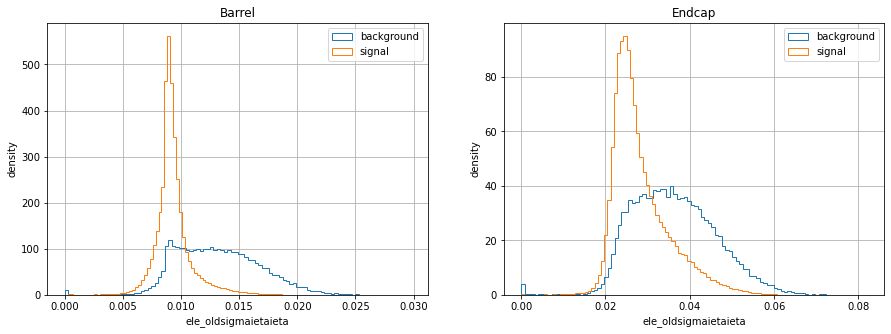

In [214]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_electrons(df.query("ele_isEB"), "ele_oldsigmaietaieta", 100, ax=axes[0], title="Barrel")
plot_electrons(df.query("ele_isEE"), "ele_oldsigmaietaieta", 100, ax=axes[1], title="Endcap")
plt.show()